# Simulation parameters

In [1]:
gyromagnetic_ratio = 42.58 # kHz / mT
size = 16
n_pulses = 2
n_angles = 8
dt = 16e-5 #32e-6
wait_dt = dt
background_std = 0.0
isochromat_std = 0.0
n_classes = 5
res = 16
pulse_lr = 2e-2
grad_lr = 2e-3
freeze_model = False
gpu_idx = 1

# Functions

## Imports

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import os
import io
from pathlib import Path
import IPython

from pynvml import *
import time

import pylab as plt
plt.style.use('dark_background')

import numpy as np
from scipy.special import binom
import math

import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.functional import pad

import cv2
import skimage.data
import skimage.transform
from skimage.transform.radon_transform import _get_fourier_filter

import h5py
import logging
from tqdm import tqdm
from tqdm.notebook import trange
from itertools import islice
from typing import List, Dict
from collections import defaultdict
from IPython import display

In [3]:
import pylab as plt
plt.style.use('dark_background')

## Field generator

In [4]:
class IdealB0Generator:

    def __init__(
            self, device: torch.device,
            angles: torch.tensor, img_shape: List[int],
            mean: float, std: float
    ):
        self.device = device
        self.angles = angles
        self.img_shape = img_shape
        self.mean = mean
        self.std = std

    @staticmethod
    def getB(theta, shape, mean, std, device):
        x = torch.arange(shape[0], device=device)[None] / shape[0]
        y = torch.arange(shape[1], device=device)[:, None] / shape[1]
        B = x * torch.sin(theta) + y * torch.cos(theta)
        B = (B - B.mean()) / (B.std() + 1e-11)
        return torch.stack([torch.zeros_like(B), torch.zeros_like(B), B * std + mean])

    def __call__(self, disable_verbose=True):
        result = []
        for angle in tqdm(self.angles, disable=disable_verbose):
            result.append(self.getB(angle.deg2rad(), self.img_shape, self.mean, self.std, self.device))
        return torch.stack(result)

## Neural network

In [5]:
class EncoderBlock(nn.Module):
    def __init__(self,
                 input_channels, 
                 output_channels,
                 norm_mode,
                 kernel = 3, 
                 stride = 1, 
                 padding = 1,
                 max_pool = True):
        super().__init__()
        self.maxpooling = max_pool
        if norm_mode == 'instance':
            self.block = nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel, stride, padding),
                nn.InstanceNorm2d(num_features = output_channels),
                nn.ReLU(),
                nn.Conv2d(output_channels, output_channels, kernel, stride, padding),
                nn.InstanceNorm2d(num_features = output_channels),
                nn.ReLU())
        elif norm_mode == 'batch':
            self.block = nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel, stride, padding),
                nn.BatchNorm2d(num_features = output_channels),
                nn.ReLU(),
                nn.Conv2d(output_channels, output_channels, kernel, stride, padding),
                nn.BatchNorm2d(num_features = output_channels),
                nn.ReLU())
        if self.maxpooling:
            self.max_pool = nn.MaxPool2d(kernel_size = 2)
    def forward(self, inputs):
        out = self.block(inputs)
        if self.maxpooling:
            return self.max_pool(out), out
        return out

    
class DecoderBlock(nn.Module):
    def __init__(self, 
                 input_channels,
                 output_channels,
                 norm_mode,
                 kernel = 3,
                 stride = 1,
                 stride_convT = 2,
                 padding = 1,
                 output_pad = 1,
                 input_channels_convT = None,
                 output_channels_convT = None,
                 dropout_proba = 0.5,
                 upsampling_mode = 'conv_transpose'):
        super().__init__()
        if upsampling_mode == 'upsampling':
            self.upsample = torch.nn.Upsample(scale_factor = 2, mode = 'bilinear')
        elif upsampling_mode == 'conv_transpose':
            self.upsample = nn.ConvTranspose2d(input_channels_convT, output_channels_convT, kernel, 
                                               stride_convT, padding, output_pad)
        self.dropout = nn.Dropout(dropout_proba)
        
        if norm_mode == 'instance':
            self.block = nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel, stride, padding),
                nn.InstanceNorm2d(output_channels),
                nn.ReLU(),
                nn.Conv2d(output_channels, output_channels, kernel, stride, padding),
                nn.InstanceNorm2d(output_channels),
                nn.ReLU())
        elif norm_mode == 'batch':
            self.block = nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel, stride, padding),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(),
                nn.Conv2d(output_channels, output_channels, kernel, stride, padding),
                nn.BatchNorm2d(output_channels),
                nn.ReLU())
        
    def forward(self, inputs, skip):
        out = self.upsample(inputs)
        out = torch.cat([out, skip], dim = 1)
        out = self.dropout(out)
        out = self.block(out)
        return out
        
        
class UNet(nn.Module):
    def __init__(self, 
                 num_classes,
                 min_channels = 32,
                 max_channels = 512, 
                 num_down_blocks = 4, 
                 img_channels = 2, 
                 dropout = 0.5,
                 upsampling_mode = 'conv_transpose',
                 norm_mode = 'instance'):
        super(UNet, self).__init__()
        self.num_down_blocks = num_down_blocks
        self.num_classes = num_classes
        self.output_channels_encoder = [min(min_channels * 2 ** i, max_channels) for i in range(num_down_blocks)]
        self.input_channels_encoder = [img_channels] + self.output_channels_encoder[:-1]
        self.input_channels_decoder = [a + b for a,b in zip(self.output_channels_encoder[::-1], 
                                                            self.input_channels_encoder[::-1])]
        self.output_channels_decoder = self.input_channels_encoder[::-1][:-1]
        self.max_pooling = [True for i in range(num_down_blocks)][:-1] + [False]
        self.convT_input = self.output_channels_encoder[1:][::-1]
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        for i in range(num_down_blocks):
             self.encoder.append(EncoderBlock(self.input_channels_encoder[i],
                                              self.output_channels_encoder[i],
                                              norm_mode = norm_mode,
                                              max_pool = self.max_pooling[i]))
        for i in range(num_down_blocks - 1):
            if upsampling_mode == 'conv_transpose':
                self.decoder.append(DecoderBlock(self.input_channels_decoder[i],
                                                 self.output_channels_decoder[i],
                                                 norm_mode=norm_mode,
                                                 input_channels_convT = self.convT_input[i],
                                                 output_channels_convT= self.convT_input[i],
                                                 dropout_proba=dropout,
                                                 upsampling_mode = upsampling_mode))
            elif upsampling_mode == 'upsampling':
                self.decoder.append(DecoderBlock(self.input_channels_decoder[i],
                                                 self.output_channels_decoder[i],
                                                 norm_mode=norm_mode,
                                                 dropout_proba=dropout,
                                                 upsampling_mode = upsampling_mode))
        self.last_layer = nn.Sequential(
            nn.Conv2d(min_channels, num_classes, kernel_size = 1),
            nn.Sigmoid())
        # self.last_layer = nn.Conv2d(min_channels, num_classes, kernel_size = 1)
        
    def forward(self, inputs):
        height = inputs.shape[-2]
        width = inputs.shape[-1]
        new_height = round(height / (2 ** self.num_down_blocks)) * 2 ** self.num_down_blocks
        new_width = round(width / (2 ** self.num_down_blocks)) * 2 ** self.num_down_blocks
        new_inputs = F.interpolate(inputs, size = (new_height, new_width))
        
        skip_con = []
        x = new_inputs
        for block in self.encoder:
            res = block(x)
            if isinstance(res, tuple):
                skip_con.append(res[1]) 
                x = res[0]
            else:
                x = res
        for block in self.decoder:
            x = block(x, skip_con.pop())
        logits = self.last_layer(x)
        logits = F.interpolate(logits, size = (height, width))
        return logits

In [6]:
def dice_loss(logits, true, eps=1e-7):
    """Computes the Sørensen–Dice loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the dice loss so we
    return the negated dice loss.
    Args:
        true: a tensor of shape [B, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        dice_loss: the Sørensen–Dice loss.
    Source: https://github.com/kevinzakka/pytorch-goodies/blob/master/losses.py
    """
    true = true.unsqueeze(dim=1)

    num_classes = logits.shape[1]
    
    true_1_hot = torch.eye(num_classes)[true.squeeze(1)].to(logits.device)
    true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
    probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)

## Shape generator

In [7]:
bernstein = lambda n, k, t: binom(n,k)* t**k * (1.-t)**(n-k)

def bezier(points, num=200):
    N = len(points)
    t = np.linspace(0, 1, num=num)
    curve = np.zeros((num, 2))
    for i in range(N):
        curve += np.outer(bernstein(N - 1, i, t), points[i])
    return curve

class Segment():
    def __init__(self, p1, p2, angle1, angle2, **kw):
        self.p1 = p1; self.p2 = p2
        self.angle1 = angle1; self.angle2 = angle2
        self.numpoints = kw.get("numpoints", 100)
        r = kw.get("r", 0.3)
        d = np.sqrt(np.sum((self.p2-self.p1)**2))
        self.r = r*d
        self.p = np.zeros((4,2))
        self.p[0,:] = self.p1[:]
        self.p[3,:] = self.p2[:]
        self.calc_intermediate_points(self.r)

    def calc_intermediate_points(self,r):
        self.p[1,:] = self.p1 + np.array([self.r*np.cos(self.angle1),
                                    self.r*np.sin(self.angle1)])
        self.p[2,:] = self.p2 + np.array([self.r*np.cos(self.angle2+np.pi),
                                    self.r*np.sin(self.angle2+np.pi)])
        self.curve = bezier(self.p,self.numpoints)


def get_curve(points, **kw):
    segments = []
    for i in range(len(points)-1):
        seg = Segment(points[i,:2], points[i+1,:2], points[i,2],points[i+1,2],**kw)
        segments.append(seg)
    curve = np.concatenate([s.curve for s in segments])
    return segments, curve

def ccw_sort(p):
    d = p-np.mean(p,axis=0)
    s = np.arctan2(d[:,0], d[:,1])
    return p[np.argsort(s),:]

def get_bezier_curve(a, rad=0.2, edgy=0):
    """ given an array of points *a*, create a curve through
    those points. 
    *rad* is a number between 0 and 1 to steer the distance of
          control points.
    *edgy* is a parameter which controls how "edgy" the curve is,
           edgy=0 is smoothest."""
    p = np.arctan(edgy)/np.pi+.5
    a = ccw_sort(a)
    a = np.append(a, np.atleast_2d(a[0,:]), axis=0)
    d = np.diff(a, axis=0)
    ang = np.arctan2(d[:,1],d[:,0])
    f = lambda ang : (ang>=0)*ang + (ang<0)*(ang+2*np.pi)
    ang = f(ang)
    ang1 = ang
    ang2 = np.roll(ang,1)
    ang = p*ang1 + (1-p)*ang2 + (np.abs(ang2-ang1) > np.pi )*np.pi
    ang = np.append(ang, [ang[0]])
    a = np.append(a, np.atleast_2d(ang).T, axis=1)
    s, c = get_curve(a, r=rad, method="var")
    x,y = c.T
    return x,y, a


def get_random_points(n=5, scale=0.8, mindst=None, rec=0):
    """ create n random points in the unit square, which are *mindst*
    apart, then scale them."""
    mindst = mindst or .7/n
    a = np.random.rand(n,2)
    d = np.sqrt(np.sum(np.diff(ccw_sort(a), axis=0), axis=1)**2)
    if np.all(d >= mindst) or rec>=200:
        return a*scale
    else:
        return get_random_points(n=n, scale=scale, mindst=mindst, rec=rec+1)

dict_colors = {'green': (1,128,1), 
               'black': (1, 1, 1), 
               'blue': (1,1,255), 
               'brown': (139,69,19), 
               'yellow': (255,255,1), 
               'deeppink': (255,20,147), 
               'orange': (255,165,1), 
               'purple': (138,43,226), 
               'white': (254,254,254),
               'pink': (255,192,203)
              }

def triangle_with_color(width, height, color):
    img_triangle = np.ones((width, height, 3), np.uint8) * 0
    mask_triangle = np.ones((width, height, 3), np.uint8) * 0

    pt1 = np.random.randint(50, height-100, size=2)
    pt1 = (pt1[0], pt1[1])

    low_line = np.random.randint(100, height - pt1[0], size=1)
    pt2 = ((pt1[0] + low_line)[0], pt1[1])

    if pt1[1] < height - pt1[1]:

        pt3_y = pt1[1] + np.random.randint(pt1[1], height - pt1[1], size=1)
    else:
        pt3_y = pt1[1] - np.random.randint(50, pt1[1], size=1)
    pt3_x = np.random.randint(min(pt1[0], pt1[0] - 50), max(pt2[0], pt2[0]+50), size=1)

    pt3 = (pt3_x[0], pt3_y[0])

    triangle = np.array( [pt1, pt2, pt3] )

    img_color = dict_colors[color]

    cv2.drawContours(img_triangle, [triangle], 0, img_color, -1)
#     cv2.drawContours(img_triangle, [triangle], 0, (255,255,255), -1)
    cv2.drawContours(mask_triangle, [triangle], 0, (255,255,255), -1)

    return img_triangle, mask_triangle


def rectangle_with_color(width, height, color):
    img_rectangle = np.ones((width, height, 3), np.uint8) * 0
    mask_rectangle = np.ones((width, height, 3), np.uint8) * 0

    low_left_point = np.random.randint(0, 200, size =2)
    max_size = max(min(low_left_point[0], low_left_point[1]), 
                   min(width - low_left_point[0], height - low_left_point[1]))

    width_rectangle = np.random.randint(50, max(150,max_size), size=1)
    height_rectangle = np.random.randint(50, max(150,max_size), size=1)

    upper_right_point = np.array([low_left_point[0] + width_rectangle, low_left_point[1] + height_rectangle])
    upper_right_point = upper_right_point.flatten()

    img_color = dict_colors[color]

    cv2.rectangle(img_rectangle,(low_left_point[0],low_left_point[1]),
                  (upper_right_point[0],upper_right_point[1]),img_color,-1)
    cv2.rectangle(mask_rectangle,(low_left_point[0],low_left_point[1]),
                  (upper_right_point[0],upper_right_point[1]),(255,255,255),-1)
    
    return img_rectangle, mask_rectangle


def circle_with_color(width, height, color):
    img_circle = np.ones((width, height, 3), np.uint8) * 0
    mask_circle = np.ones((width, height, 3), np.uint8) * 0

    center_x = np.random.randint(100, 200, size=1)[0]
    center_y = np.random.randint(100, height-100, size=1)[0]
    max_radius = min(50, min(min(center_x, center_y), min(width - center_x, height - center_y)))
    radius = np.random.randint(40, max_radius)

    img_color = dict_colors[color]
    cv2.circle(img_circle,(center_y,center_x), radius, img_color, -1)  
    cv2.circle(mask_circle,(center_y,center_x), radius, (255,255,255), -1)
    
    return img_circle, mask_circle


def hexagon_with_color(width, height, color):
    image = np.random.randint(0, 1, size=(width, height, 3)) 
    image = np.asarray(image, dtype="uint8")
    
    image_mask = np.random.randint(0, 1, size=(width, height, 3))
    image_mask = np.asarray(image_mask, dtype="uint8")
    
    x0 = np.random.randint(10, int(image.shape[1]*(1/3)), size=1)[0]
    diff_x = np.random.randint(int(image.shape[1]*(1/6)), int(image.shape[1]*(1/4)), size=1)[0]
    x1 = x0 + diff_x
    x2 = x1 + diff_x

    y0 = np.random.randint(5, int(image.shape[0]*(1/4)), size=1)[0]
    diff_y = np.random.randint(int(image.shape[0]*(1/6)), int(image.shape[0]*(1/5)), size=1)[0]
    y1 = y0 + diff_y
    y2 = y1 + diff_y
    y3 = y2 + diff_y

    xy_leftdown = [x0, y1]
    xy_leftup = [x0, y2]
    xy_up = [x1, y3]
    xy_rightup = [x2, y2]
    xy_rightdown = [x2, y1]
    xy_down = [x1, y0]

    pts = np.array([xy_leftdown, xy_leftup, xy_up, xy_rightup, xy_rightdown, xy_down], np.int32)
    pts = pts.reshape((-1, 1, 2))
    isClosed = True

    img_color = dict_colors[color]
    img = cv2.fillPoly(image, [pts], img_color)  
    
    mask = cv2.fillPoly(image_mask, [pts], (255,255,255))
    
    return img, mask


def trapezoid_with_color(width, height, color):
    image = np.random.randint(0, 1, size=(width, height, 3)) 
    image = np.asarray(image, dtype="uint8")
    
    image_mask = np.random.randint(0, 1, size=(width, height, 3))
    image_mask = np.asarray(image_mask, dtype="uint8")
    
    x0 = np.random.randint(10, int(image.shape[1]*(1/3)), size=1)[0]
    diff_x = np.random.randint(int(image.shape[1]*(1/6)), int(image.shape[1]*(1/4)), size=1)[0]
    x1 = x0 + diff_x
    x3 = np.random.randint(int(image.shape[1]*(3/4)), image.shape[1]-20, size=1)[0]
    x2 = x3 - diff_x

    y0 = np.random.randint(5, int(image.shape[0]*(1/3)), size=1)[0]
    diff_y = np.random.randint(int(image.shape[0]*(1/5)), int(image.shape[0]*(3/5)), size=1)[0]
    y1 = y0 + diff_y

    pts = np.array([[x0, width-y0], [x1, width-y1], 
                    [x2, width-y1], [x3, width-y0]], np.int32)
    pts = pts.reshape((-1, 1, 2))
    isClosed = True

    img_color = dict_colors[color]
    img = cv2.fillPoly(image, [pts], img_color)  
    
    mask = cv2.fillPoly(image_mask, [pts], (255,255,255))
    
    return img, mask


def star_with_color(width, height, color):
    image = np.random.randint(0, 1, size=(width, height, 3)) 
    image = np.asarray(image, dtype="uint8")
    
    image_mask = np.random.randint(0, 1, size=(width, height, 3)) 
    image_mask = np.asarray(image_mask, dtype="uint8")
    
    x0 = np.random.randint(10, int(image.shape[1]*(1/5)), size=1)[0]
    diff_x = np.random.randint(int(image.shape[1]*(1/7)), int(image.shape[1]*(1/5)), size=1)[0]
    x1 = x0 + int(1.4*diff_x)
    x4 = np.random.randint(int(image.shape[1]*(4/5)), image.shape[1]-20, size=1)[0]
    x3 = x4 - int(1.4*diff_x)
    x2 = (x1 + x3) // 2

    y0 = np.random.randint(5, int(image.shape[0]*(1/5)), size=1)[0]
    diff_y = np.random.randint(int(image.shape[0]*(1/9)), int(image.shape[0]*(1/6)), size=1)[0]
    y1 = y0 + diff_y
    y2 = y1 + diff_y
    y3 = y2 + int(1.5*diff_y)
    y4 = y3 + int(1.5*diff_y)

    pts = np.array([[x0, width-y0], [x1, width-y2], [x0, width-y3],
                   [x1, width-y3], [x2, width-y4], [x3, width-y3],
                   [x4, width-y3], [x3, width-y2], [x4, width-y0], 
                   [x2, width-y1]], np.int32)
    
    pts = pts.reshape((-1, 1, 2))
    isClosed = True

    img_color = dict_colors[color]
    img = cv2.fillPoly(image, [pts], img_color)  
    
    mask = cv2.fillPoly(image_mask, [pts], (255,255,255))
    
    return img, mask


def cross_with_color(width, height, color):
    image = np.random.randint(0, 1, size=(width, height, 3)) 
    image = np.asarray(image, dtype="uint8")
    
    image_mask = np.random.randint(0, 1, size=(width, height, 3)) 
    image_mask = np.asarray(image_mask, dtype="uint8")
    
    x0 = np.random.randint(10, int(image.shape[1]*(1/5)), size=1)[0]
    diff_x = np.random.randint(int(image.shape[1]*(1/7)), int(image.shape[1]*(1/4)), size=1)[0]
    x1 = x0 + int(1.5*diff_x)
    x3 = np.random.randint(int(image.shape[1]*(3/4)), image.shape[1]-int(image.shape[1]*(1/5)), size=1)[0]
    x2 = x3 - int(1.5*diff_x)

    y0 = np.random.randint(5, int(image.shape[0]*(1/5)), size=1)[0]
    diff_y = np.random.randint(int(image.shape[0]*(1/7)), int(image.shape[0]*(1/4)), size=1)[0]
    y1 = y0 + int(1.5*diff_y)
    y3 = np.random.randint(int(image.shape[0]*(3/4)), image.shape[0]-int(image.shape[0]*(1/5)), size=1)[0]
    y2 = y3 - int(1.5*diff_y)

    pts = np.array([[x0, width-y1], [x0, width-y2], [x1, width-y2],
                   [x1, width-y3], [x2, width-y3], [x2, width-y2],
                   [x3, width-y2], [x3, width-y1], [x2, width-y1], 
                   [x2, width-y0], [x1, width-y0], [x1, width-y1]], np.int32)
    
    pts = pts.reshape((-1, 1, 2))
    isClosed = True

    img_color = dict_colors[color]
    img = cv2.fillPoly(image, [pts], img_color)  
    
    mask = cv2.fillPoly(image_mask, [pts], (255,255,255))
    
    return img, mask


def get_img_from_fig(fig, dpi):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img


# a = [5, 13]
# b = [1, 3]

def heart_with_color(width, height, color, dpi=1):
    a = np.random.randint(5, 13, size=1)[0]
    b = np.random.randint(1, 3, size=1)[0]
    
    theta = np.linspace(0, 2 * np.pi, 100)
    x = a * (np.sin(theta) ** 3 )
    y = a * np.cos(theta) - 1 * np.cos(b*theta) - 2 * np.cos((b+1)*theta) - np.cos((b+2)*theta)
    
    fig1 = plt.figure(figsize=(height, width))
    plt.style.use('dark_background')
    plt.fill(x, y, color)
    plt.axis('off')
    plt.close(fig1)
    
    fig2 = plt.figure(figsize=(height, width))
    plt.style.use('dark_background')
    plt.fill(x, y, 'white')
    plt.axis('off')
    plt.close(fig2)
    
    heart_img = get_img_from_fig(fig1, dpi)
    heart_mask = get_img_from_fig(fig2, dpi)
    return heart_img, heart_mask


def moon_with_color(width, height, color):
    img_color = dict_colors[color] 
   
    moon_img = np.ones((width, height, 3), np.uint8) * 0
    moon_mask = np.ones((width, height, 3), np.uint8) * 0
    x = np.random.randint(100, 200, size=1)[0]
    y = np.random.randint(100, 200, size=1)[0]
    r_1 = np.random.randint(50, 100, size=1)[0]
    r_2 = np.random.randint(40, 80, size=1)[0]
    cv2.circle(moon_img, (x, y), r_1, img_color, -1) 
    cv2.circle(moon_img, (x + r_2-10, y), r_2, (0, 0, 0), -1) 

    cv2.circle(moon_mask, (x, y), r_1, (255,255,255), -1) 
    cv2.circle(moon_mask, (x + r_2-10, y), r_2, (0, 0, 0), -1)  

    return moon_img, moon_mask 



def cloud_with_color(width, height, color):
    choise = np.random.randint(2, 4, size=1)[0]
    img_color = dict_colors[color] 
    cloud_img = np.ones((width, height, 3), np.uint8) * 0
    cloud_mask = np.ones((width, height, 3), np.uint8) * 0
    x = np.random.randint(100, 200, size=1)[0]
    y = np.random.randint(100, 200, size=1)[0]
    if choise == 2:
        cv2.circle(cloud_img, (x, y), 60, img_color, -1) 
        cv2.circle(cloud_img, (x + 50, y), 40, img_color, -1) 
        cv2.circle(cloud_img, (x - 50, y), 40, img_color, -1)

        cv2.circle(cloud_mask, (x, y), 60, (255,255,255), -1) 
        cv2.circle(cloud_mask, (x + 50, y), 40, (255,255,255), -1) 
        cv2.circle(cloud_mask, (x - 50, y), 40, (255,255,255), -1)
    elif choise == 3:    
        cv2.circle(cloud_img, (x, y), 60, img_color, -1) 
        cv2.circle(cloud_img, (x + 40, y), 50, img_color, -1) 
        cv2.circle(cloud_img, (x - 40, y), 50, img_color, -1)
        cv2.circle(cloud_img, (x + 80, y), 25, img_color, -1) 
        cv2.circle(cloud_img, (x - 80, y), 25, img_color, -1)

        cv2.circle(cloud_mask, (x, y), 60, (255,255,255), -1) 
        cv2.circle(cloud_mask, (x + 40, y), 50, (255,255,255), -1) 
        cv2.circle(cloud_mask, (x - 40, y), 50, (255,255,255), -1)
        cv2.circle(cloud_mask, (x + 80, y), 25, (255,255,255), -1) 
        cv2.circle(cloud_mask, (x - 80, y), 25, (255,255,255), -1)

    return cloud_img, cloud_mask  

def add_zero(x):
    return pad(x, (1, 0))

def minmax_scale(x):
    return 2 * (x - x.min()) / (x.max() - x.min()) - 1.

def get_random_shape(size=(64, 64), n_points=7, center=(0., 0.), scale=1.):
    fig, _ = plt.subplots(figsize=(10, 10), dpi=90)

    a = get_random_points(n=n_points, scale=1.)
    x, y, _ = get_bezier_curve(a - a.mean(0, keepdims=True), rad=0.5, edgy=0.01)
    x, y = minmax_scale(x), minmax_scale(y)
    plt.fill_between(x, np.zeros_like(y), y, facecolor='w')

    plt.xlim((-1. - center[0]) / scale, (1. - center[0]) / scale)
    plt.ylim((-1. - center[1]) / scale, (1. - center[1]) / scale)

    plt.axis('off')
    io_buf = io.BytesIO()
    plt.tight_layout()
    fig.savefig(io_buf, format='raw')
    io_buf.seek(0)
    img_arr = np.reshape(np.frombuffer(io_buf.getvalue(), dtype=np.uint8),
                        newshape=(int(fig.bbox.bounds[3]), int(fig.bbox.bounds[2]), -1))
    img = torch.from_numpy(cv2.resize(img_arr[:,:,0], size)).float()
    io_buf.close()
    plt.close()
    return img

def generate_phantom_mask(n_shapes, complexity=8, size=(64, 64), center_range=(-0.4, 0.4), scale_range=(.4, .8)):
    shapes = torch.stack([torch.zeros(size)] + [
        get_random_shape(size, n_points=complexity,
            center=np.random.uniform(*center_range, 2),
            scale=np.random.uniform(*scale_range)
        ) / 255 for _ in range(n_shapes)
    ])
    mask = shapes.cumsum(0).argmax(0)
    return mask

def sort_classes(mask):
    order = mask.flatten().bincount().argsort(descending=True)
    return order.argsort()[mask]

t1_values = torch.tensor([0.0, 2.0048, 2.4663, 4.8941, 2.4135])
t2_values = torch.tensor([0.0, 2.9737, 5.3960, 6.5332, 3.6534])
rho_values = torch.tensor([0.0, 149.0, 249.0, 73.0, 44.0])  

## Initialization

In [8]:
assert gpu_idx < torch.cuda.device_count()
device = torch.device('cuda:'+str(gpu_idx) if torch.cuda.is_available() else 'cpu')
np.random.seed(2)

# Setup image phantom
np.random.seed(2)
mask = generate_phantom_mask(4, size=(size, size))
mask = sort_classes(mask)

rho_map = rho_values[mask]
t1_map = t1_values[mask]
t2_map = t2_values[mask]

# Degine model
unet_config = {
        "num_classes": n_classes,
        "min_channels": 32,
        "max_channels": 512,
        "num_down_blocks": 3,
        "img_channels": n_pulses,
        "dropout": 0.5,
        "upsampling_mode": "upsampling",
        "norm_mode": "instance"
}

model = UNet(**unet_config).to(device)
!gdown -q 10O-MbNR8hXEg8LnM2Ncr92KxYIegNezu --output checkpoints_1.pth # 1 slice
!gdown -q 1uHQ91IqGmMXbGuEe1XgZfWH9sdp5nBm- --output checkpoints_2.pth # 2 slice
!gdown -q 1Wi5yTnndMBz8-vPRBIoo1oQpX2GFoeVh --output checkpoints_3.pth # 3 slice    

checkpoint = torch.load("checkpoints_"+str(n_pulses)+".pth")
model.load_state_dict(checkpoint['model_state_dict'])

criterion = nn.CrossEntropyLoss()
if not freeze_model:
  model_opt = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-4)

dice_accumulation = []
acc_accumulation = []

# Generate timesteps
timespaces = [
    torch.arange(-0.05, 0.0, wait_dt)[:-1],       # wait
    torch.arange(0.0, 0.0235, dt)[:-1],      # pulse90
    torch.arange(0.0235, 0.2, wait_dt)[:-1],      # wait
]
add_timespaces = [
    [
        torch.arange(0.2 + 0.4 * i, 0.2235 + 0.4 * i, dt)[:-1],      # pulse180
        torch.arange(0.2235 + 0.4 * i, 0.37 + 0.4 * i, wait_dt)[:-1],     # wait
        torch.arange(0.37 + 0.4 * i, 0.42 + 0.4 * i, dt)[:-1],       # read
        torch.arange(0.42 + 0.4 * i, 0.6 + 0.4 * i, wait_dt)[:-1],        # wait
    ]
    for i in range(n_pulses)
]
add_timespaces = [v for s in add_timespaces for v in s]

timespaces = timespaces + add_timespaces
timespace = torch.cat(timespaces)
timesteps = len(timespace)

# Generate fields
angles = torch.arange(0, 360, step=360/n_angles)
n_isochromats = n_angles * size * size * 1

## Background
B_background = torch.randn(3, n_isochromats, device=device) * background_std
## Field grad
B_grad = IdealB0Generator(torch.device('cpu'), angles, [size, size], mean=0., std=4.)()
## B0
B0 = torch.ones_like(B_grad) * 190
B0[:, :2] = 0
## B1
B1 = torch.stack([torch.ones(size,size) * 0.525, torch.zeros(size,size), torch.zeros(size,size)])

# Reshape fields for simulator
B0_simulator = B0.movedim(0, -1).flatten(1).to(device)
B_grad_simulator = B_grad.movedim(0,-1).flatten(1).to(device)
B1_simulator = B1.repeat(1 * n_angles, 1, 1, 1).movedim(0,-1).flatten(1).to(device)

# # Generate amplitudes
# grad_amplitude = torch.zeros_like(timespace)

# def find_idx(t):
#   return (abs(np.array(timespace)-t)).argmin()

# for i in range(n_pulses):
#   grad_amplitude[find_idx(0.2235 + 0.4 * i):find_idx(0.2935 + 0.4 * i)] = -1
#   grad_amplitude[find_idx(0.33 + 0.4 * i):find_idx(0.47 + 0.4 * i)] = 1
#   grad_amplitude[find_idx(0.5065 + 0.4 * i):find_idx(0.5765 + 0.4 * i)] = -1

# grad_amplitude = torch.Tensor(grad_amplitude).to(device)

# rf_amplitude = torch.zeros_like(timespace)
# rf_amplitude[find_idx(0):find_idx(0.0235)] = 1
# for i in range(n_pulses):
#   rf_amplitude[find_idx(0.2 + 0.4*i):find_idx(0.2235 + 0.4*i)] = 2

# rf_amplitude = torch.Tensor(rf_amplitude).to(device)

# rf_amplitude.requires_grad_()
# grad_amplitude.requires_grad_()

# sim_opt = torch.optim.SGD([rf_amplitude, grad_amplitude], lr=sim_lr, weight_decay=1e-4)

In [9]:
def triangle_kernel(t, pulse_time, width=1., slope=2.):
    return slope * torch.clamp(1 - torch.abs(pulse_time - t) / width, 0)

def trapezoid_kernel(t, pulse_time, width=1., slope=2.):
    return slope * torch.clamp(1 - torch.abs(pulse_time - t) / width, 0, 1 / slope)

pulse_width = 0.0235 / 2

pulse_times = torch.tensor([0] + [.2 + .4 * i for i in range(n_pulses)]) + pulse_width
pulse_amps = torch.tensor([1.] + [2.] * n_pulses)

sinusoid = torch.sin(2 * math.pi * timespace * 190 * gyromagnetic_ratio).to(device)

pulse_times.to(device)
pulse_amps.to(device)

pulse_times.requires_grad_()
pulse_amps.requires_grad_()

grad_widths = torch.tensor([[.035, .07, .035] for _ in range(n_pulses)]).flatten()
grad_times = torch.tensor([[.2235 + .4 * i, .33 + .4 * i, .5065 + .4 * i] for i in range(n_pulses)]).flatten() + grad_widths
grad_amps = torch.tensor([[-1., 1., -1.] for _ in range(n_pulses)]).flatten()

grad_widths.to(device)
grad_times.to(device)
grad_amps.to(device)

# grad_widths.requires_grad_()
grad_times.requires_grad_()
grad_amps.requires_grad_()

pulse_opt = torch.optim.SGD([pulse_times, pulse_amps], lr=pulse_lr)
grad_opt = torch.optim.SGD([grad_times, grad_amps], lr=grad_lr)

## Simulator

In [10]:
class SliceBlochSimulator2:

    def __init__(self,
            rho_map: torch.tensor, t1_map: torch.tensor, t2_map: torch.tensor,
            timespace: torch.tensor, B_total: torch.tensor,
            angles: torch.tensor, mstd: float, num_isochromats_per_voxel: int,
            device: torch.device,
    ):
        self.device = device

        assert rho_map.shape == t1_map.shape == t2_map.shape
        assert len(rho_map.shape) == 2, f'img_phantom must be 2d, but got {rho_map.shape}'
        assert len(angles.shape) == 1

        self.B_total = B_total
        
        self.num_isochromats_per_voxel = num_isochromats_per_voxel
        H, W = rho_map.shape
        num_rotations = angles.shape[0]
        
        self.rho_map = rho_map.to(device)
        self.angles = angles.to(device)
        self.num_rotations = num_rotations
        self.total_isochromats = num_rotations * H * W * num_isochromats_per_voxel

        self.timespace = timespace.to(device)
        self.M = torch.randn(3, self.total_isochromats, device=self.device) * mstd
        self.M += torch.eye(3)[2].to(device)[:, None]
        self.M *= self.rho_map[None, None]\
            .repeat(num_isochromats_per_voxel * len(angles),1,1,1)\
            .movedim(0,-1)\
            .flatten(1)
        self.t1_map = t1_map.to(device)[None, None]\
            .repeat(num_isochromats_per_voxel * len(angles),1,1,1)\
            .movedim(0,-1)\
            .flatten(1)[0]
        self.t2_map = t2_map.to(device)[None, None]\
            .repeat(num_isochromats_per_voxel * len(angles),1,1,1)\
            .movedim(0,-1)\
            .flatten(1)[0]
        
        self.Mh = torch.zeros((self.num_rotations, 3, self.timespace.shape[0] - 1), dtype=torch.float32)

    @staticmethod
    def getR(B, dt):
        Bnorm = B.norm(dim=0)
        nx = B[0] / Bnorm
        ny = B[1] / Bnorm
        nz = B[2] / Bnorm
        phi = dt * gyromagnetic_ratio * Bnorm * 2 * math.pi
        R11 = nx ** 2 + (1 - nx ** 2) * torch.cos(phi)
        R12 = nx * ny * (1 - torch.cos(phi)) + nz * torch.sin(phi)
        R13 = nx * nz * (1 - torch.cos(phi)) - ny * torch.sin(phi)
        R21 = nx * ny * (1 - torch.cos(phi)) - nz * torch.sin(phi)
        R22 = nx ** 2 + (1 - nx ** 2) * torch.cos(phi)
        R23 = ny * nz * (1 - torch.cos(phi)) + nx * torch.sin(phi)
        R31 = nx * nz * (1 - torch.cos(phi)) + ny * torch.sin(phi)
        R32 = ny * nz * (1 - torch.cos(phi)) - nx * torch.sin(phi)
        R33 = nz ** 2 + (1 - nz ** 2) * torch.cos(phi)
        R = torch.stack([
            torch.stack([R11, R12, R13]),
            torch.stack([R21, R22, R23]),
            torch.stack([R31, R32, R33])
        ])
        return R.T

    def simulate(self, verbose: bool = True):
        pbar = tqdm(enumerate(self.timespace[1:]), total=len(self.timespace[1:]), disable=not verbose, mininterval=2, maxinterval=30)
        pbar.set_description('M computing')

        for i, t in pbar:
            B = self.B_total[:,:,i]
            dt = t - self.timespace[i]
            dt = dt.to(device)
            self.M = torch.matmul(self.getR(-B, dt), self.M.T[:, :, None])[:, :, 0].T
            self.M = (self.M[0] * torch.exp(-dt / self.t2_map)) * torch.eye(3, device=device)[0][:, None] +\
                     (self.M[1] * torch.exp(-dt / self.t2_map)) * torch.eye(3, device=device)[1][:, None] +\
                     (self.M[2] * torch.exp(-dt / self.t1_map) + (1 - torch.exp(-dt / self.t1_map))) * torch.eye(3, device=device)[2][:, None]  
            self.Mh[:, :, i] = self.M.view(3, -1, self.num_rotations).mean(1).swapaxes(0, 1).cpu()
        return self.Mh

## Reconstruction

In [11]:
def get_art_recon(simulator, M, t1, t2, B_readout):
    angle_step = 1
    time_step = 1
    angles = simulator.angles[::angle_step]
    B0_readout = B_readout[::angle_step, :, ::1, ::1]
    IH, IW = B0_readout.shape[-2:]
    target_H = res

    SE_t = simulator.timespace\
    [(simulator.timespace - t1).abs().argmin():(simulator.timespace - t2).abs().argmin()]\
    [M[:,1].cpu().abs()[
            :,
            (simulator.timespace - t1).abs().argmin():(simulator.timespace - t2).abs().argmin()
        ].mean(0).argmax()
    ].item()

    t1 = SE_t - target_H / ((B0_readout[:, 2].max() - B0_readout[:, 2].min()) * gyromagnetic_ratio)
    t2 = SE_t + target_H / ((B0_readout[:, 2].max() - B0_readout[:, 2].min()) * gyromagnetic_ratio)

    time = simulator.timespace[(simulator.timespace - t1).abs().argmin():(simulator.timespace - t2).abs().argmin()].cpu()[::time_step]
    se_data = M[:,1][:, (simulator.timespace - t1).abs().argmin():(simulator.timespace - t2).abs().argmin()].cpu()[::angle_step, ::time_step]

    se = se_data * (-2j * math.pi * B0_readout[:, 2, IH//2, IW//2][:, None] * gyromagnetic_ratio * (time[None] - SE_t)).exp()
    baseband = torch.fft.ifftshift(torch.fft.fft(se, dim=-1), dim=-1)
    freq = torch.fft.ifftshift(torch.fft.fftfreq(se.shape[1], d=(time[-1] - time[0]) / time.shape[0]))

    baseband[:, :baseband.shape[-1]//2 - target_H] = 0
    baseband[:, baseband.shape[-1]//2 + target_H:] = 0

    baseband = baseband[:, baseband.shape[-1]//2 - target_H:baseband.shape[-1]//2 + target_H].abs()
    freq = freq[baseband.shape[-1]//2 - target_H:baseband.shape[-1]//2 + target_H]
    
    se_down = torch.fft.fft(torch.fft.ifftshift(baseband, dim=-1), dim=-1)
    se_down = torch.fft.ifftshift(se_down, dim=-1)
    sd = baseband
    time = torch.nn.functional.interpolate(time[None, None], size=[se_down.shape[-1]])[0,0]

    E = torch.zeros([angles.shape[0], time.shape[0], IH*IW]).cfloat()
    for i, theta in enumerate(angles):
        E[i] = torch.exp(1j * 2 * math.pi * ((-B0_readout[i][2].flatten() + B0_readout[i, 2, IH//2, IW//2]) * gyromagnetic_ratio)[None] * (time - SE_t)[:, None]).cfloat()
    E = E.to(device)

    m_old = torch.zeros((IH, IW)).view(-1, 1).cfloat()
    m_old = m_old.to(device)
    _se_data = se_down.to(device)

    pbar = tqdm(range(1000))
    pbar.set_description('Slice generation')

    for i in pbar:
        update = (((_se_data.roll(0,0) - (E @ m_old.cfloat())[:, :, 0]) / E.norm(p=2, dim=2))[:, None] * E.transpose(1, 2).conj()).mean([0,2]).view(-1, 1)
        m_old = m_old + 5e-2 * update

    rimg = m_old.reshape(IH, IW).abs()

    return rimg, [t1,t2]

## Tracking function

In [12]:
def plot_initial(read_times, simulator, rho_map, t1_map, t2_map, mask, logits, vec_img, M, rf_amplitude, grad_amplitude):
  nvmlInit()
  h = nvmlDeviceGetHandleByIndex(0)
  info = nvmlDeviceGetMemoryInfo(h)
  print(f'Memory: total:{info.total/1024/1024}; free:{info.free/1024/1024}; used:{info.used/1024/1024}')

  plt.figure(figsize=(20,2.5))
  plt.title("Amplitudes")
  plt.plot(timespace, rf_amplitude.tolist(), label="rf amplitude")
  plt.plot(timespace, grad_amplitude.tolist(), label="grad amplitude")
  plt.xlabel("Time")
  plt.legend()

  # N = 0
  # plt.figure(figsize=(19,1.5))
  # plt.title("Magnetization")
  # plt.xticks(simulator.timespace.cpu()[::500], rotation=90)
  # plt.plot(simulator.timespace.cpu(), M[N,0].cpu().detach(), c='g')
  # plt.twinx()
  # plt.plot(simulator.timespace.cpu(), (M[N,2].cpu().detach() / M[N,2].cpu().detach().max()).arccos().rad2deg().cpu(), c='r')
  # plt.show()

  plt.figure(figsize=(20,4))
  plt.subplot(171)
  plt.title("Rho map")
  plt.imshow(rho_map, cmap=plt.cm.bone)
  plt.axis('off')
  plt.subplot(172)
  plt.title("T1 map")
  plt.imshow(t1_map, cmap=plt.cm.bone)
  plt.axis('off')
  plt.subplot(173)
  plt.title("T2 map")
  plt.imshow(t2_map, cmap=plt.cm.bone)
  plt.axis('off')
  plt.subplot(174)
  plt.title("MRI slice 1")
  plt.imshow(vec_img[0].tolist(), cmap=plt.cm.bone)
  plt.axis('off')
  plt.subplot(175)
  plt.title("MRI slice 2")
  plt.imshow(vec_img[1].tolist(), cmap=plt.cm.bone)
  plt.axis('off')
  plt.subplot(176)
  plt.title("True mask")
  plt.imshow(mask)
  plt.axis('off')
  plt.subplot(177)
  plt.title("Predicted mask")
  plt.imshow(logits.cpu().detach().argmax(1).reshape(16,16))
  plt.axis('off')
  plt.show()

In [13]:
def plot_result(read_times, simulator, rho_map, t1_map, t2_map, mask, logits, vec_img, M, backward, rf_amplitude, grad_amplitude):
  nvmlInit()
  h = nvmlDeviceGetHandleByIndex(0)
  info = nvmlDeviceGetMemoryInfo(h)
  print(f'Memory: total:{info.total/1024/1024}; free:{info.free/1024/1024}; used:{info.used/1024/1024}')

  plt.figure(figsize=(20,2.5))
  plt.title("Amplitudes")
  plt.plot(timespace, rf_amplitude.tolist(), label="rf amplitude")
  plt.plot(timespace, grad_amplitude.tolist(), label="grad amplitude")
  plt.xlabel("Time")
  plt.legend()

  # N = 0
  # plt.figure(figsize=(19,1.5))
  # plt.title("Magnetization")
  # plt.xticks(simulator.timespace.cpu()[::500], rotation=90)
  # plt.plot(simulator.timespace.cpu(), M[N,0].cpu().detach(), c='g')
  # # plt.ylim(-7, 7)
  # plt.twinx()
  # plt.plot(simulator.timespace.cpu(), (M[N,2].cpu().detach() / M[N,2].cpu().detach().max()).arccos().rad2deg().cpu(), c='r')
  # plt.xlabel("Time")
  # plt.show()

  plt.figure(figsize=(20,4))
  plt.subplot(171)
  plt.title("Rho map")
  plt.imshow(rho_map, cmap=plt.cm.bone)
  plt.axis('off')
  plt.subplot(172)
  plt.title("T1 map")
  plt.imshow(t1_map, cmap=plt.cm.bone)
  plt.axis('off')
  plt.subplot(173)
  plt.title("T2 map")
  plt.imshow(t2_map, cmap=plt.cm.bone)
  plt.axis('off')
  plt.subplot(174)
  plt.title("MRI slice 1")
  plt.imshow(vec_img[0].tolist(), cmap=plt.cm.bone)
  plt.axis('off')
  plt.subplot(175)
  plt.title("MRI slice 2")
  plt.imshow(vec_img[1].tolist(), cmap=plt.cm.bone)
  plt.axis('off')
  plt.subplot(176)
  plt.title("True mask")
  plt.imshow(mask)
  plt.axis('off')
  plt.subplot(177)
  plt.title("Predicted mask")
  plt.imshow(logits.cpu().detach().argmax(1).reshape(16,16))
  plt.axis('off')
  plt.show()

  if backward:
    plt.figure(figsize=(20,2.5))
    plt.title("Gradients")
    if rf_amplitude.grad is None:
      plt.plot(timespace, rf_amplitude.tolist(), label="rf amplitude")
      plt.quiver(pulse_times.data.cpu(), pulse_amps.data.cpu(),
                 pulse_times.grad.cpu(), pulse_amps.grad.cpu(), label="rf gradient", color="C0")
    else:
      plt.plot(timespace, rf_amplitude.grad.cpu(), label="rf amplitude")
      
    if grad_amplitude.grad is None:
      plt.plot(timespace, grad_amplitude.tolist(), label="grad amplitude")
      plt.quiver(grad_times.data.cpu(), grad_amps.data.cpu(),
                 grad_times.grad.cpu(), grad_amps.grad.cpu(), label="rf gradient", color="C1")
    else:
      plt.plot(timespace, grad_amplitude.grad.cpu(), label="grad amplitude")
    plt.legend()
    plt.xlabel("Time")

      # lim_max = max(torch.cat([rf_amplitude.grad.cpu(), grad_amplitude.grad.cpu()]))
      # lim_min = min(torch.cat([rf_amplitude.grad.cpu(), grad_amplitude.grad.cpu()]))

      # plt.vlines(0, lim_min, lim_max, colors='r')
      # plt.vlines(0.0235, lim_min, lim_max, colors='r')
      # plt.vlines(0.2, lim_min, lim_max, colors='b')
      # plt.vlines(0.2235, lim_min, lim_max, colors='b')
      # for time in read_times:
      #   plt.vlines(time, lim_min, lim_max, colors='g')
  else:
    plt.figure(figsize=(20,2.5))
    plt.title("Gradients")
    plt.plot(timespace, torch.zeros_like(timespace), label="rf amplitude")
    plt.plot(timespace, torch.zeros_like(timespace), label="grad amplitude")
    plt.legend()

  plt.figure(figsize=(20,2.5))
  plt.title("Metrics")
  plt.plot(acc_accumulation, label="Accuracy")
  plt.plot(dice_accumulation, label="Dice")
  plt.xlabel("Epoch")
  plt.legend()
  
  for i in range(n_pulses):
    plt.figure(figsize=(10,4))
    plt.subplot(131)
    plt.title("Initial")
    plt.imshow(initial_vec_img[i].tolist(), cmap=plt.cm.bone)
    plt.axis('off')
    plt.subplot(132)
    plt.title("Optimized")
    plt.imshow(vec_img[i].tolist(), cmap=plt.cm.bone)
    plt.axis('off')
    plt.subplot(133)
    plt.title("Difference")
    plt.imshow((initial_vec_img[i] - vec_img[i]).tolist(), cmap=plt.cm.bone)
    plt.axis('off')
    plt.show()

## Run one epoch

In [14]:
def run_initial():
  with torch.no_grad():
    model.eval()
    # Fill total field
    B_total = B_background.unsqueeze(-1).repeat(1,1,timesteps).to(device)
    pbar = tqdm(enumerate(timespace[1:]), total=len(timespace[1:]), mininterval=2, maxinterval=30)
    pbar.set_description('B_total filling')

    # Generate kernels
    rf_amplitude = torch.zeros_like(timespace)

    for pulse_time, pulse_amp in zip(pulse_times, pulse_amps):
        window_ix = torch.abs(timespace - pulse_time) <= pulse_width
        rf_amplitude[window_ix] += pulse_amp * triangle_kernel(timespace[window_ix], pulse_time, pulse_width)

    grad_amplitude = torch.zeros_like(timespace)

    for grad_time, grad_amp, grad_width in zip(grad_times, grad_amps, grad_widths):
        window_ix = torch.abs(timespace - grad_time) <= grad_width
        grad_amplitude[window_ix] += grad_amp * trapezoid_kernel(timespace[window_ix], grad_time, grad_width)


    for i, t in pbar:
        B_total[:,:,i] += B0_simulator
        B_total[:,:,i] += B1_simulator * sinusoid[i] * rf_amplitude[i]
        B_total[:,:,i] += B_grad_simulator * grad_amplitude[i]
        B_total[:,:,i] += torch.randn_like(B_total[:,:,i]) * isochromat_std

    # Run simulator
    simulator = SliceBlochSimulator2(
        rho_map=rho_map, t1_map=t1_map, t2_map=t2_map,
        timespace=timespace, B_total=B_total,    
        angles=angles, mstd=0, num_isochromats_per_voxel=1,
        device=device,  
    )

    M = simulator.simulate()
    simulator.timespace = simulator.timespace[1:]

    # Read slices
    read_times = [
        [0.31 + 0.4 * i, 0.47 + 0.4 * i]
        for i in range(n_pulses)
    ]
    vec_img = []
    new_read_times = []
    for (t1, t2) in read_times:
        rimg, times = get_art_recon(simulator, M, t1, t2, B_grad + B0)
        vec_img.append(rimg)
        new_read_times = [*new_read_times, *times]

    vec_img = torch.stack(vec_img)

    global initial_vec_img
    initial_vec_img = vec_img

    # Net usage
    logits = model.forward(vec_img.unsqueeze(0))
    loss = criterion(logits, mask.unsqueeze(0).to(device))

    dice = 1 - dice_loss(logits,  mask.unsqueeze(0).to(device)).item()
    acc = (logits.argmax(1) == mask.unsqueeze(0).to(device)).float().mean().item()

    dice_accumulation.append(dice)
    acc_accumulation.append(acc)

    print("Initial DICE:", round(dice, 2))
    print("Initial Acc:", round(acc, 2))

    # Tracking
    plot_initial(new_read_times, simulator, rho_map, t1_map, t2_map, mask, logits, vec_img, M, rf_amplitude, grad_amplitude)

In [15]:
def run_epoch(backward=False, verbose=True):
  ### Training part
  pulse_opt.zero_grad()
  grad_opt.zero_grad()
  if not freeze_model:
    model_opt.zero_grad()
    model.train()
  else:
    model.eval()

  # Fill total field
  B_total = B_background.unsqueeze(-1).repeat(1,1,timesteps).to(device)
  pbar = tqdm(enumerate(timespace[1:]), total=len(timespace[1:]), mininterval=2, maxinterval=30)
  pbar.set_description('B_total filling')

  # Generate kernels
  rf_amplitude = torch.zeros_like(timespace)

  for pulse_time, pulse_amp in zip(pulse_times, pulse_amps):
    window_ix = torch.abs(timespace - pulse_time) <= pulse_width
    rf_amplitude[window_ix] += pulse_amp * triangle_kernel(timespace[window_ix], pulse_time, pulse_width)

  grad_amplitude = torch.zeros_like(timespace)

  for grad_time, grad_amp, grad_width in zip(grad_times, grad_amps, grad_widths):
    window_ix = torch.abs(timespace - grad_time) <= grad_width
    grad_amplitude[window_ix] += grad_amp * trapezoid_kernel(timespace[window_ix], grad_time, grad_width)

  for i, t in pbar:
      B_total[:,:,i] += B0_simulator
      B_total[:,:,i] += B1_simulator * sinusoid[i] * rf_amplitude[i]
      B_total[:,:,i] += B_grad_simulator * grad_amplitude[i]
      B_total[:,:,i] += torch.randn_like(B_total[:,:,i]) * isochromat_std

  # Run simulator
  simulator = SliceBlochSimulator2(
      rho_map=rho_map, t1_map=t1_map, t2_map=t2_map,
      timespace=timespace, B_total=B_total,    
      angles=angles, mstd=0, num_isochromats_per_voxel=1,
      device=device,  
  )

  M = simulator.simulate()
  simulator.timespace = simulator.timespace[1:]

  # Read slices
  read_times = [
      [0.31 + 0.4 * i, 0.47 + 0.4 * i]
      for i in range(n_pulses)
  ]
  vec_img = []
  new_read_times = []
  for (t1, t2) in read_times:
      rimg, times = get_art_recon(simulator, M, t1, t2, B_grad + B0)
      vec_img.append(rimg)
      new_read_times = [*new_read_times, *times]

  vec_img = torch.stack(vec_img)

  # Net usage
  logits = model.forward(vec_img.unsqueeze(0))
  loss = criterion(logits, mask.unsqueeze(0).to(device))

  # Differentiation
  if backward:
    loss.backward()
    pulse_times.grad.clamp_max_(.05)
    grad_times.grad.clamp_max_(.05)

  pulse_opt.step()
  grad_opt.step()
  if not freeze_model:
    model_opt.step()

  ### Validation part

  with torch.no_grad():
    model.eval()
    # Fill total field
    B_total = B_background.unsqueeze(-1).repeat(1,1,timesteps).to(device)
    pbar = tqdm(enumerate(timespace[1:]), total=len(timespace[1:]), mininterval=2, maxinterval=30)
    pbar.set_description('B_total filling')

    for i, t in pbar:
        B_total[:,:,i] += B0_simulator
        B_total[:,:,i] += B1_simulator * sinusoid[i] * rf_amplitude[i]
        B_total[:,:,i] += B_grad_simulator * grad_amplitude[i]
        B_total[:,:,i] += torch.randn_like(B_total[:,:,i]) * isochromat_std

    # Run simulator
    simulator = SliceBlochSimulator2(
        rho_map=rho_map, t1_map=t1_map, t2_map=t2_map,
        timespace=timespace, B_total=B_total,    
        angles=angles, mstd=0, num_isochromats_per_voxel=1,
        device=device,  
    )

    M = simulator.simulate()
    simulator.timespace = simulator.timespace[1:]

    # Read slices
    read_times = [
        [0.31 + 0.4 * i, 0.47 + 0.4 * i]
        for i in range(n_pulses)
    ]
    vec_img = []
    new_read_times = []
    for (t1, t2) in read_times:
        rimg, times = get_art_recon(simulator, M, t1, t2, B_grad + B0)
        vec_img.append(rimg)
        new_read_times = [*new_read_times, *times]

    vec_img = torch.stack(vec_img)

    # Net usage
    logits = model.forward(vec_img.unsqueeze(0))
    loss = criterion(logits, mask.unsqueeze(0).to(device))

    dice = 1 - dice_loss(logits,  mask.unsqueeze(0).to(device)).item()
    acc = (logits.argmax(1) == mask.unsqueeze(0).to(device)).float().mean().item()

    dice_accumulation.append(dice)
    acc_accumulation.append(acc)

  # Tracking
  if verbose:
    IPython.display.clear_output()
    plot_result(new_read_times, simulator, rho_map, t1_map, t2_map, mask, logits, vec_img, M, backward,
                rf_amplitude, grad_amplitude)


# Run optimization

Slice generation: 100%|██████████| 1000/1000 [00:00<00:00, 3262.54it/s]


Initial DICE: 0.29
Initial Acc: 0.73
Memory: total:32508.1875; free:5866.5625; used:26641.625


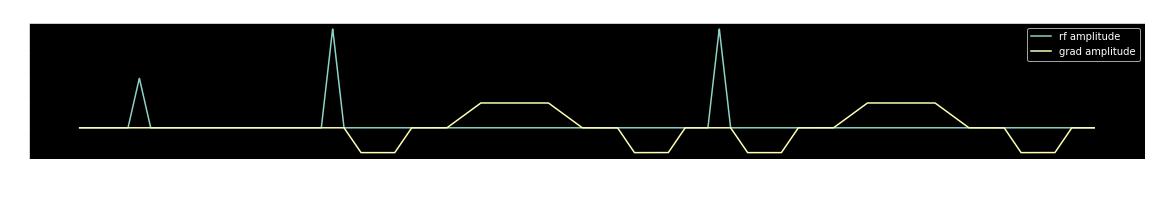

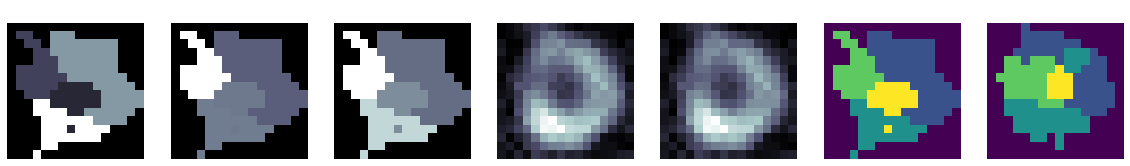

In [16]:
run_initial()

In [17]:
for _ in range(10):
  run_epoch(backward=True, verbose=False)

Slice generation: 100%|██████████| 1000/1000 [00:00<00:00, 3738.89it/s]


Memory: total:32508.1875; free:5866.5625; used:26641.625


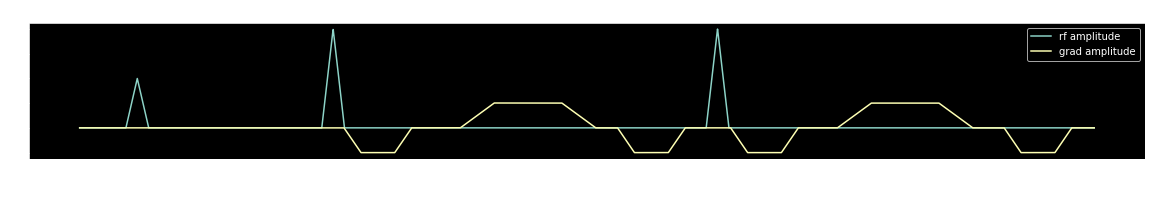

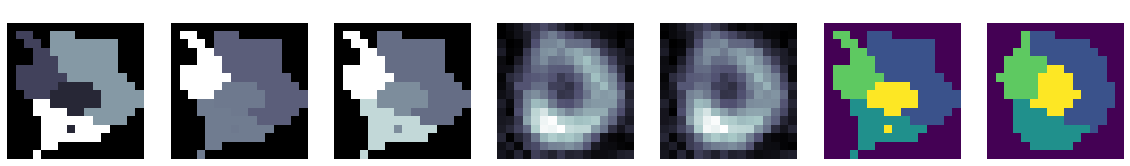

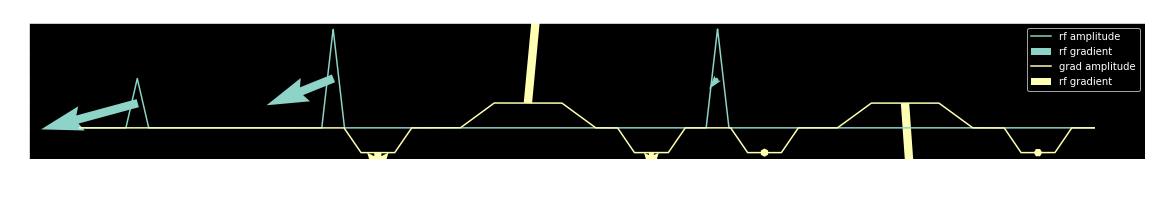

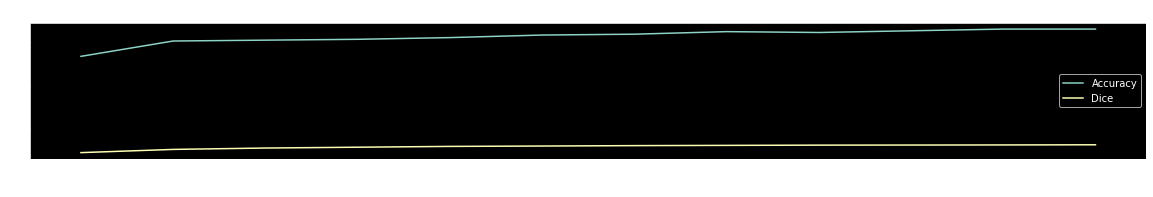

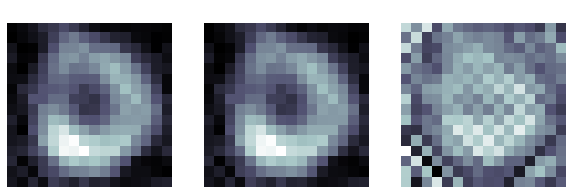

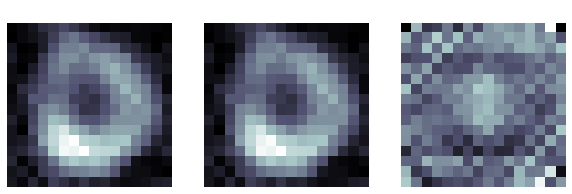

In [18]:
run_epoch(backward=True)